In [1]:
!pip install ultralytics torch torchvision torchaudio scikit-learn opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 32.0 MB/s eta 0:00:00


In [4]:
from google.colab import drive
drive.mount('/content/drive')
import os, glob, math, json, time, collections, random
import numpy as np
import cv2
from pathlib import Path
import torch, torch.nn as nn, torch.optim as optim
from ultralytics import YOLO
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

def make_dirs(d):
    os.makedirs(d, exist_ok=True)

def timestamp():
    return time.strftime('%Y%m%d_%H%M%S')

Mounted at /content/drive
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


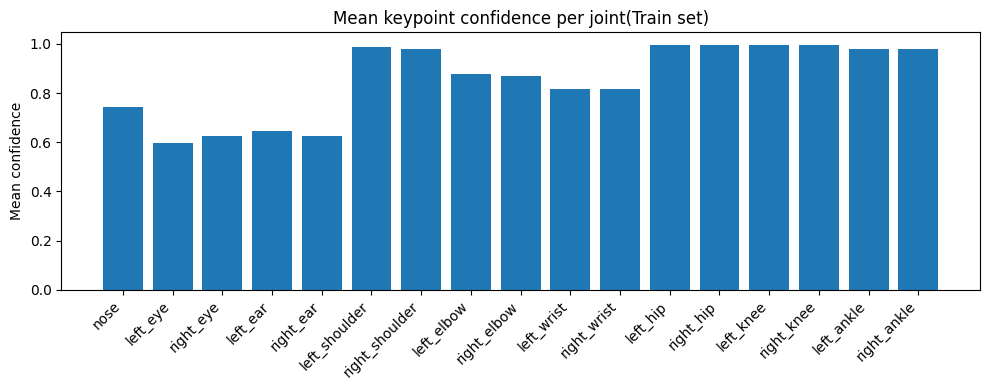

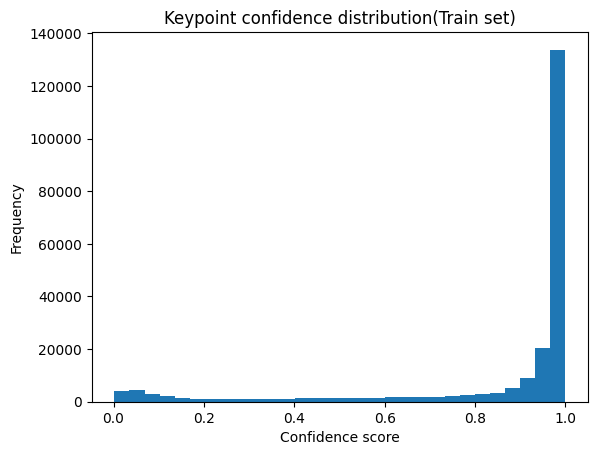

Detection success rate: 1.000
Zero-feature frame ratio: 0.000
Mean temporal jitter: 0.0065
Std temporal jitter: 0.0033


In [5]:
class KeypointExtractor:

    def __init__(self, device='cpu'):
        print("Loading YOLO11 Pose model...")
        self.model = YOLO('yolo11n-pose.pt')
        self.device = device
        self.feature_dim = 51  # 17 keypoints × 3 (x, y, confidence)

    def extract(self, frame):
        """Extract keypoints from frame.

        Returns:
            np.array of shape (51,): flattened [x1,y1,conf1, x2,y2,conf2, ...]
        """
        try:
            results = self.model(frame, imgsz=640, device=self.device, verbose=False)

            if len(results) == 0 or not hasattr(results[0], 'keypoints'):
                return np.zeros(self.feature_dim, dtype=np.float32)

            kpts = results[0].keypoints

            if kpts is None or len(kpts) == 0:
                return np.zeros(self.feature_dim, dtype=np.float32)

            # Get first person's keypoints
            kpt_data = kpts.data[0].cpu().numpy()  # Shape: (17, 3)

            # Normalize coordinates by frame dimensions
            h, w = frame.shape[:2]
            kpt_data[:, 0] /= w  # Normalize x
            kpt_data[:, 1] /= h  # Normalize y

            # Flatten to 1D
            features = kpt_data.flatten()

            return features.astype(np.float32)

        except Exception as e:
            print(f"Keypoint extraction failed: {e}")
            return np.zeros(self.feature_dim, dtype=np.float32)

# FEATURE CACHE
class VideoFeatureCache:

    def __init__(self, cache_dir):
        self.cache_dir = Path(cache_dir)
        self.cache_dir.mkdir(parents=True, exist_ok=True)

    def cache_path(self, video_path):
        fname = Path(video_path).stem + '.npy'
        return self.cache_dir / fname

    def exists(self, video_path):
        return self.cache_path(video_path).exists()

    def save(self, video_path, arr):
        try:
            np.save(str(self.cache_path(video_path)), arr)
        except Exception as e:
            print(f"Warning: Failed to save cache for {video_path}: {e}")

    def load(self, video_path):
        try:
            return np.load(str(self.cache_path(video_path)))
        except Exception as e:
            print(f"Warning: Failed to load cache for {video_path}: {e}")
            return None

# FEATURE EXTRACTION
def precompute_keypoint_features_adaptive(videos, extractor, cache, seq_length=16):
    """Pre-extract keypoint features"""

    print("\n" + "="*60)
    print("KEYFRAME EXTRACTION + FEATURE EXTRACTION")
    print("="*60)

    keyframe_extractor = AdaptiveKeyframeExtractor(target_frames=seq_length)
    feature_dim = extractor.feature_dim
    videos_to_process = [v for v in videos if not cache.exists(v)]

    if len(videos_to_process) == 0:
        print("All features already cached!")
        return

    print(f"Processing {len(videos_to_process)} videos...\n")

    for video_path in tqdm(videos_to_process, desc="Extracting features"):
        try:
            # Get frame indices
            frame_indices = keyframe_extractor.extract_frame_indices(video_path)

            # Extract features from selected frames
            cap = cv2.VideoCapture(video_path)
            feats = []

            for frame_idx in frame_indices:
                cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
                ok, frame = cap.read()

                if not ok:
                    break

                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                feat = extractor.extract(frame)
                feats.append(feat)

            cap.release()

            # Pad if needed
            if len(feats) < seq_length:
                if len(feats) == 0:
                    feats = [np.zeros(feature_dim, dtype=np.float32)] * seq_length
                else:
                    last = feats[-1]
                    while len(feats) < seq_length:
                        feats.append(last.copy())

            arr = np.stack(feats[:seq_length], axis=0).astype(np.float32)
            cache.save(video_path, arr)

        except Exception as e:
            print(f"\nError: {video_path}: {e}")
            zero_features = np.zeros((seq_length, feature_dim), dtype=np.float32)
            cache.save(video_path, zero_features)

    print("\n Feature extraction complete")

#Evaluation for Yolopose

KEYPOINT_NAMES = [
    "nose", "left_eye", "right_eye", "left_ear", "right_ear",
    "left_shoulder", "right_shoulder", "left_elbow", "right_elbow",
    "left_wrist", "right_wrist", "left_hip", "right_hip",
    "left_knee", "right_knee", "left_ankle", "right_ankle"
]

def analyze_keypoint_confidence(cache_dir):
    cache_dir = Path(cache_dir)
    all_confidences = []

    for f in cache_dir.glob("*.npy"):
        feats = np.load(f)  # (T, 51)
        conf = feats[:, 2::3]  # (T, 17)
        all_confidences.append(conf)

    all_confidences = np.concatenate(all_confidences, axis=0)  # (N_frames, 17)

    mean_conf = all_confidences.mean(axis=0)

    # Plot per-joint mean confidence
    plt.figure(figsize=(10, 4))
    plt.bar(KEYPOINT_NAMES, mean_conf)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel("Mean confidence")
    plt.title("Mean keypoint confidence per joint(Train set)")
    plt.tight_layout()
    plt.show()

    # Global confidence histogram
    plt.figure()
    plt.hist(all_confidences.flatten(), bins=30)
    plt.xlabel("Confidence score")
    plt.ylabel("Frequency")
    plt.title("Keypoint confidence distribution(Train set)")
    plt.show()

    return mean_conf

def detection_success_rate(cache_dir, conf_threshold=0.1):
    cache_dir = Path(cache_dir)
    total_frames = 0
    detected_frames = 0
    zero_frames = 0

    per_video_rates = {}

    for f in cache_dir.glob("*.npy"):
        feats = np.load(f)  # (T, 51)
        conf = feats[:, 2::3]  # (T, 17)

        total_frames += feats.shape[0]

        frame_detected = (conf.mean(axis=1) > conf_threshold)
        detected_frames += frame_detected.sum()
        zero_frames += np.all(feats == 0, axis=1).sum()

        per_video_rates[f.stem] = frame_detected.mean()

    print(f"Detection success rate: {detected_frames / total_frames:.3f}")
    print(f"Zero-feature frame ratio: {zero_frames / total_frames:.3f}")

    return per_video_rates

def temporal_jitter_metrics(cache_dir):
    cache_dir = Path(cache_dir)
    jitters = []

    for f in cache_dir.glob("*.npy"):
        feats = np.load(f)  # (T, 51)
        coords = feats[:, 0::3][:, :, None], feats[:, 1::3][:, :, None]
        xy = np.concatenate(coords, axis=2)  # (T, 17, 2)

        if xy.shape[0] < 2:
            continue

        diff = np.linalg.norm(xy[1:] - xy[:-1], axis=2)  # (T-1, 17)
        jitters.append(diff.mean())

    mean_jitter = np.mean(jitters)
    std_jitter = np.std(jitters)

    print(f"Mean temporal jitter: {mean_jitter:.4f}")
    print(f"Std temporal jitter: {std_jitter:.4f}")

    return mean_jitter, std_jitter

CACHE_DIR_YOLO = "/content/drive/MyDrive/cache_train"


mean_conf = analyze_keypoint_confidence(CACHE_DIR_YOLO)

video_detection_rates = detection_success_rate(CACHE_DIR_YOLO)

mean_jitter, std_jitter = temporal_jitter_metrics(CACHE_DIR_YOLO)


